$\textbf{Function approximation TD(0) tailored for the reset application}$

The pseudo-code for function approximation TD(0) tailored for the reset application can be found in Algorithm 1.

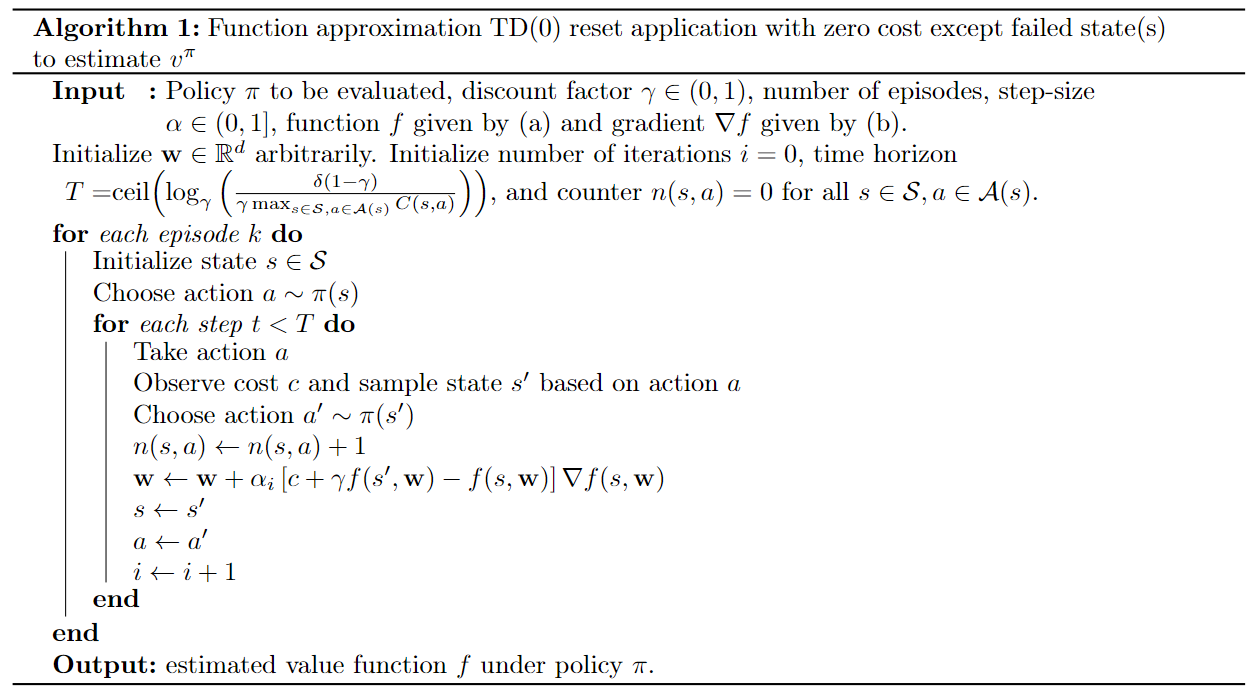

Here, 
\begin{align*}
   (a)&= f(s,\mathbf{w})=\begin{cases}
    \frac{\mathbf{w}(0) \cdot c^\pi(N)}{1-\gamma \cdot \mathbf{w}(0)}, & \text{if }s=0,\\
    \mathbf{w}(s)\cdot\left(c^\pi(N)+\gamma\cdot  \frac{\mathbf{w}(0)\cdot c^\pi(N)}{1-\gamma \cdot \mathbf{w}(0)}\right) ,&\text{if } s\in \{1,...,N-1\},\\
     c^\pi(N)+\gamma\cdot \frac{\mathbf{w}(0) \cdot c^\pi(N)}{1-\gamma\cdot \mathbf{w}(0)},  & \text{if }s=N.
    \end{cases}\\
    (b)&= \nabla f(s,\mathbf{w})=c^\pi(N)\cdot\left( \frac{{1}\{s=0\}+\gamma {1}\{s\neq0\}}{(1-\gamma \cdot \mathbf{w}(0))^{2}}\cdot \mathbf{e}_0+{1}\{s\neq 0,s\neq N\}\cdot\mathbf{e}_s\right).
\end{align*}

The implementation for this algorithm can be found in the code below.

In [1]:

import numpy as np
import time
import matplotlib.pyplot as plt


# f(s,w): the function (a)
def f(s,w,gamma,C_1,N):
    if s==0:
        f_s = w[0]*C_1[N]/(1-gamma*w[0])
    elif s==N:
        #f_s = C_1[N] + gamma*w[0]*C_1[N]/(1-gamma*w[0])
        f_s = C_1[N]/(1-gamma*w[0])
    else:
        #f_s = w[s]*(C_1[N] + gamma*w[0]*C_1[N]/(1-gamma*w[0]))
        f_s = w[s]*C_1[N]/(1-gamma*w[0])
    
    return f_s

# gradient of f(s,w): the function (b)
def grad_f(s,w,gamma,C_1,N):
    w_size=np.size(w)
    d_f=np.zeros(w_size)
    if s==0:
        d_f[0] = C_1[N]/((1-gamma*w[0])**2)
    elif s==N:
        d_f[0] = gamma*C_1[N]/((1-gamma*w[0])**2)
    else:
        d_f[0] = gamma*C_1[N]/((1-gamma*w[0])**2)
        d_f[s] = C_1[N]
    
    return d_f


def Function_approx_TD_zero(alpha, gamma,P,C_0,C_1, pi_s, nrepisodes):
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
    alpha_type = alpha
    
    # size of the state space-1
    N=np.size(P,1)-1
    
    # state space S
    S=np.arange(N+1)
    
    # Initialize Q-values by 0, here the rows correspond to the action and columns to the state
    # i.e., Q is of the form Q[s,a]
    Q=np.zeros([N+1,2])
    
    # setting the Q value for "illegal" actions to infinity
    Q[0,1]=float("inf")
    Q[N,0]=float("inf")
    
    # initialize weights vector w of size |S|
    w = np.zeros(N+1)
    
    # nr of iterations
    it=0
    
    # preselect time-horizon T
    delta=0.000001 # error margin
    C_0[N]=0 # setting cost "illegal" actions to zero
    C_1[0]=0 # setting cost "illegal" actions to zero
    C=np.array([C_0,C_1])   
    T=round(np.log((delta*(1-gamma))/(C.max()))/np.log(gamma)-1) # time-horizon T
    
    # Q[s,a,iteration number]: array to keep track of the Q-values per iteration
    Q_it=np.zeros([N+1,2,(nrepisodes)*T])
    
    # w[s, iteration number]: array to keep track of the weights per iteration
    w_it=np.zeros([N+1,(nrepisodes)*T])
    
    # Q[s,a,episode number]: array to keep track of the Q-values per episode
    Q_ep=np.zeros([N+1,2,nrepisodes])
    
    # w[s,episode number]: array to keep track of the weights per episode
    w_ep=np.zeros([N+1,nrepisodes])
    
    # f[s, iteration number]: array to keep track of the approximated value function per iteration
    f_it=np.zeros([N+1,(nrepisodes)*T])
    
    # f[s,episode number]: array to keep track of the approximated value function per iteration
    f_ep=np.zeros([N+1,nrepisodes])
    
    # n_it[s,a] denotes the number of times (s,a) is visited
    n_it=np.zeros([N+1,2])
    
    # array to keep track of the actions, costs, states, and step-size at each iteration
    a_it = np.zeros((nrepisodes)*T)
    r_it = np.zeros((nrepisodes)*T)
    s_it = np.zeros((nrepisodes)*T)
    alpha_it = np.zeros([N+1,2,(nrepisodes)*T])
    
    # loop for each episode
    for e in range(1,nrepisodes+1):
        
        # randomly selecting and storing initial state
        state =  np.random.randint(0, N+1)
        

        # choosing the action according to our policy
        action = pi_s[state]

            
        # loop for t=0,1,...,T-1
        for t in range(T): 

            # taking action A_t 
            # observing and storing the next reward as R_{t+1}
            # and sampling the next state S_{t+1} according to P   
            if action==1:
                next_state = 0
                reward = C_1[state] 
            elif action==0:
                next_state = np.random.choice(S,p=P[state,:])
                reward = C_0[state]
            
            # keeping track of the states, actions, and costs for each iteration
            s_it[it]=state
            a_it[it]=action
            r_it[it]=reward


            # choosing the next action according to our policy
            next_action = pi_s[next_state]

             
            # incrementing the nr of visits to (s,a) by 1    
            n_it[state,action]+=1    
            
            # in case we want to use an alpha depending on the iteration nr:
            if alpha_type == 10:
                alpha=1/np.log(it+3)  # +3 to make sure alpha<=1
                
            if alpha_type == 40:
                alpha=1/np.log(n_it[state,action]+2)
            
            if alpha_type == 20:
                alpha=1/n_it[state,action]
                
            if alpha_type == 30:
                alpha=1/(it+1)
                
                
            
            alpha_it[state,action,it]=alpha
            
            # updating the Q-values
            Q[state,action]+=alpha*(reward+ gamma*Q[next_state,next_action]-Q[state,action])
            

            # dw = alpha_t * ( c(s,a) + gamma*f(s',w)-f(s,w) ) * gradient_f(s,w) 
            w += alpha*(reward+gamma*f(next_state,w,gamma,C_1,N)-f(state,w,gamma,C_1,N))*grad_f(state,w,gamma,C_1,N)
            
            # storing the Q(s,a)-update per iteration
            Q_it[state,action,it] = Q[state,action]
            
            # storing the weights update per iteration
            w_it[:,it]=w
            
            # storing the state-function value per iteration
            f_it[:,it]=f(state,w,gamma,C_1,N)
            
            # increment the number of iterations by 1
            it+=1   
            
            # s <- s'
            state = next_state
            
            # a <- a'
            action = next_action
        
        # keeping track of the approximation value function, weights, and Q-values at each episode
        f_ep[:,e-1] = np.array([f(s,w,gamma,C_1,N) for s in range(0,N+1)]) 
        w_ep[:,e-1] = w
        Q_ep[:,0,e-1] = Q[:,0]
        Q_ep[:,1,e-1] = Q[:,1]
    
    return Q, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w, w_it, w_ep, Q_ep, f_ep






Initializing the algorithm's parameters:

In [2]:

# discount factor
gamma=0.3

# number of states - 1
N=3

# nr of episodes
nrepisodes = 1000

# step-size alpha:
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
alpha=20

# Initializing the policy
pi_s = np.zeros(N+1,dtype=int)
pi_s[N]=1


# Realization 1

# Cost for action = 0
C_0=np.zeros(N+1)

# Cost for action = 1
C_1=np.arange(N+1,dtype=float)
C_1[N]=2*N

# P_B
P = np.diag(1/2*np.ones(N),1)+np.diag(1/2*np.ones(N),-1)
P[-1,-2]=1
P[0,1]=1



Next, we compute the optimal value and optimal policy exactly using Policy Iteration. This exact solution will then be used to compute the MAE, MSE and %WP.

In [3]:


# policy evaluation
def Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s):
    N=np.size(P,1)-1
    
    P_pi=P.copy()
    
    # nonzeros(pi_s) returns the index of the nonzero elements, i.e. action=1
    # in the rows corresponding to this index we change the P
    # so that we will reset to state 0 w.p. 1
    P_pi[np.nonzero(pi_s)]=np.identity(N+1)[0]
    
    C=C_0.copy()
    C[np.nonzero(pi_s)]=C_1[np.nonzero(pi_s)]
    
    # x=linalg.solve(a,b) solves ax=b
    # in our case we solve (I-gamma*P)V=C
    Vn = np.linalg.solve(np.identity(N+1)-gamma*P_pi,C)
    
    return Vn


# policy improvement step
def Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,Vn):  
    # initializing N and several value functions
    N=np.size(P,1)-1
    Vn_0=np.zeros(N+1)
    Vn_1=np.zeros(N+1)
    
    # value function if action=0 was chosen for all states
    Vn_0=C_0+gamma*P@Vn 
    # value function if action=1 was chosen for all states
    Vn_1=C_1+gamma*np.repeat(Vn[0],N+1) 
    
    
    # finding the action that minimizes the value function for each state
    # here, axis=0 looks for row (=action) for which the value in the column (=state) is minimized
    policy=np.argmin(np.array([Vn_0,Vn_1]),axis=0)
    
    return policy 



# step-size alpha:
    # in case we want to use one of the four alpha depending on the iteration
    # alpha_type = 10: alpha = 1/log(t)
    # alpha_type = 20: alpha = 1/n_t(s)
    # alpha_type = 30: alpha = 1/t
    # alpha_type = 40: alpha = 1/log(n_t(s))
Q_fix, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_fix, w_it, w_ep_fix, Q_ep, f_ep_fix = Function_approx_TD_zero(0.1, gamma,P,C_0,C_1, pi_s, nrepisodes)
Q_logt, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_logt, w_it, w_ep_logt, Q_ep, f_ep_logt = Function_approx_TD_zero(10, gamma,P,C_0,C_1, pi_s, nrepisodes)
Q_n, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_n, w_it, w_ep_n, Q_ep, f_ep_n = Function_approx_TD_zero(20, gamma,P,C_0,C_1, pi_s, nrepisodes)
Q_t, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_t, w_it, w_ep_t, Q_ep, f_ep_t = Function_approx_TD_zero(30, gamma,P,C_0,C_1, pi_s, nrepisodes)
Q_logn, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_logn, w_it, w_ep_logn, Q_ep, f_ep_logn = Function_approx_TD_zero(40, gamma,P,C_0,C_1, pi_s, nrepisodes)

# Putting the cost for "illegal actions" to infinity
C_0[N]=float("inf")
C_1[0]=float("inf")


# Initializing the value function
V=np.zeros(N+1)

# Initializing the policy
pi_s = np.ones(N+1,dtype=int)
pi_s[0]=0

# Number of iterations counter
it=0
while True:
    # Policy evaluation for policy pi_s
    V=Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s)
    
    # Policy improvement of policy pi_s
    policy = Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,V)
    
    # Incrementing the number of iterations by 1
    it+=1
    
    # Checking if the policy has changed
    if all(pi_s==policy):
        break
    
    # Assigning the improved policy to pi_s
    pi_s=policy.copy()





Creating a plot for the estimated value by the algorithm for state 0, for various step-sizes:

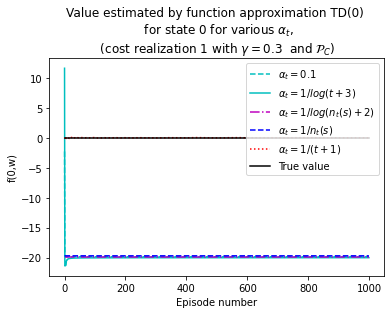

In [4]:
s=0


Q_plot=f_ep_fix[s,:]

plt.plot(np.arange(nrepisodes),Q_plot,'c--',label=r'$\alpha_t=0.1$', ms=3 )



Q_plot=f_ep_logt[s,:]

plt.plot(np.arange(nrepisodes),Q_plot,'c-',label=r'$\alpha_t=1/log(t+3)$', ms=3 )


Q_plot=f_ep_logn[s,:]

plt.plot(np.arange(nrepisodes),Q_plot,'m-.',label=r'$\alpha_t=1/log(n_t(s)+2)$', ms=3 )


Q_plot=f_ep_n[s,:]

plt.plot(np.arange(nrepisodes),Q_plot,'b--',label=r'$\alpha_t=1/n_t(s)$', ms=3 )



Q_plot=f_ep_t[s,:]

plt.plot(np.arange(nrepisodes),Q_plot,'r:',label=r'$\alpha_t=1/(t+1)$', ms=3 )



plt.plot(np.arange(nrepisodes),np.ones(nrepisodes)*V[s],'k-',label='True value',ms=4 ) # for s=3


plt.title('Value estimated by function approximation TD(0) \n'+' for state '+str(s)+r' for various $\alpha_t$,'+'\n (cost realization 1 with $\gamma=$'+str(gamma)+r'  and $\mathcal{P}_C$) ')
plt.xlabel('Episode number')
plt.ylabel('f('+str(s)+',w)')
plt.legend()

Next, we compute the optimal value and optimal policy exactly using Policy Iteration. This exact solution will then be used to compute the MAE, MSE and %WP.

In [5]:

nrruns=100

# Putting the cost for "illegal actions" to infinity
C_0[N]=float("inf")
C_1[0]=float("inf")


# Initializing the value function
V=np.zeros(N+1)

# Initializing the policy
pi_s = np.ones(N+1,dtype=int)
pi_s[0]=0

# Number of iterations counter
it=0
while True:
    # Policy evaluation for policy pi_s
    V=Policy_Evaluation_2_actions(gamma,P,C_0,C_1,pi_s)
    
    # Policy improvement of policy pi_s
    policy = Policy_Improvement_2_actions(gamma,P,C_0,C_1,pi_s,V)
    
    # Incrementing the number of iterations by 1
    it+=1
    
    # Checking if the policy has changed
    if all(pi_s==policy):
        break
    
    # Assigning the improved policy to pi_s
    pi_s=policy.copy()


opt_policy = policy.copy()




MSE_sarsa_0_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_1_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_2_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_3_it = np.zeros([nrruns,nrepisodes])
MSE_sarsa_4_it = np.zeros([nrruns,nrepisodes])


MAE_sarsa_0_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_1_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_2_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_3_it = np.zeros([nrruns,nrepisodes])
MAE_sarsa_4_it = np.zeros([nrruns,nrepisodes])

policy_count_eps0 = np.zeros([nrruns,nrepisodes])
policy_count_eps1 = np.zeros([nrruns,nrepisodes])
policy_count_eps2 = np.zeros([nrruns,nrepisodes])
policy_count_eps3 = np.zeros([nrruns,nrepisodes])
policy_count_eps4 = np.zeros([nrruns,nrepisodes])

for i in range(0,nrruns):
    Q_fix, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_fix, w_it, w_ep_fix, Q_ep, f_ep_fix = Function_approx_TD_zero(0.1, gamma,P,C_0,C_1, pi_s, nrepisodes)
    Q_logt, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_logt, w_it, w_ep_logt, Q_ep, f_ep_logt = Function_approx_TD_zero(10, gamma,P,C_0,C_1, pi_s, nrepisodes)
    Q_n, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_n, w_it, w_ep_n, Q_ep, f_ep_n = Function_approx_TD_zero(20, gamma,P,C_0,C_1, pi_s, nrepisodes)
    Q_t, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_t, w_it, w_ep_t, Q_ep, f_ep_t = Function_approx_TD_zero(30, gamma,P,C_0,C_1, pi_s, nrepisodes)
    Q_logn, T, it, Q_it, n_it, a_it, s_it, r_it, alpha_it, w_logn, w_it, w_ep_logn, Q_ep, f_ep_logn = Function_approx_TD_zero(40, gamma,P,C_0,C_1, pi_s, nrepisodes)


    
    #1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
    MSE_sarsa_0_it[i,:] = np.mean(np.array([(f_ep_fix[j,:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_1_it[i,:] = np.mean(np.array([(f_ep_logt[j,:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_2_it[i,:] = np.mean(np.array([(f_ep_n[j,:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_3_it[i,:] = np.mean(np.array([(f_ep_t[j,:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    MSE_sarsa_4_it[i,:] = np.mean(np.array([(f_ep_logn[j,:]-V[j])**2 for j in range(0,N+1)]),axis=0)
    
    # 1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
    MAE_sarsa_0_it[i,:] = np.mean(np.array([abs(f_ep_fix[j,:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_1_it[i,:] = np.mean(np.array([abs(f_ep_logt[j,:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_2_it[i,:] = np.mean(np.array([abs(f_ep_n[j,:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_3_it[i,:] = np.mean(np.array([abs(f_ep_t[j,:]-V[j]) for j in range(0,N+1)]),axis=0)
    MAE_sarsa_4_it[i,:] = np.mean(np.array([abs(f_ep_logn[j,:]-V[j]) for j in range(0,N+1)]),axis=0)
    
    
    #MSE_sarsa_3_it[np.logical_not(np.isnan(MSE_sarsa_3_it))]


# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N (Q(s,pi^*(s))-V(s))^2 computed for each episode
MSE_sarsa_0 = np.mean(MSE_sarsa_0_it, axis=0)
MSE_sarsa_1 = np.mean(MSE_sarsa_1_it, axis=0)
MSE_sarsa_2 = np.mean(MSE_sarsa_2_it, axis=0)
MSE_sarsa_3 = np.mean(MSE_sarsa_3_it, axis=0)
MSE_sarsa_4 = np.mean(MSE_sarsa_4_it, axis=0)


# 1/nrruns * sum_{i=1}^nrruns  1/(N+1) * sum_{s=0}^N |Q(s,pi^*(s))-V(s)| computed for each episode
MAE_sarsa_0 = np.mean(MAE_sarsa_0_it, axis=0)
MAE_sarsa_1 = np.mean(MAE_sarsa_1_it, axis=0)
MAE_sarsa_2 = np.mean(MAE_sarsa_2_it, axis=0)
MAE_sarsa_3 = np.mean(MAE_sarsa_3_it, axis=0)
MAE_sarsa_4 = np.mean(MAE_sarsa_4_it, axis=0)


Creating the plots:

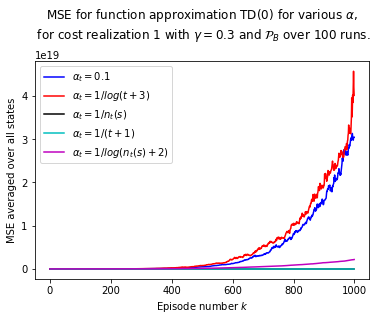

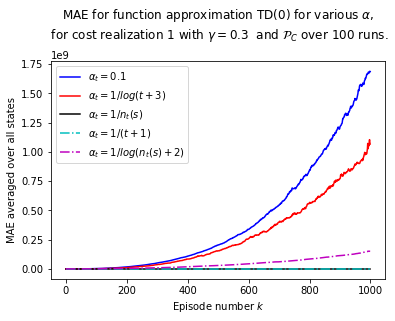

In [6]:
fig0, ax0 = plt.subplots()


ax0.plot(np.arange(np.size(MSE_sarsa_0)),MSE_sarsa_0,'b-',label=r'$\alpha_t=0.1$')

ax0.plot(np.arange(np.size(MSE_sarsa_1)),MSE_sarsa_1,'r-',label=r'$\alpha_t=1/log(t+3)$')

ax0.plot(np.arange(np.size(MSE_sarsa_2)),MSE_sarsa_2,'k-',label=r'$\alpha_t=1/n_t(s)$')

ax0.plot(np.arange(np.size(MSE_sarsa_3)),MSE_sarsa_3,'c-',label=r'$\alpha_t=1/(t+1)$')

ax0.plot(np.arange(np.size(MSE_sarsa_4)),MSE_sarsa_4,'m-',label=r'$\alpha_t=1/log(n_t(s)+2)$')
#ax0.set(xlim=(0, nrepisodes), ylim=(100000,100000))



plt.title(r'MSE for function approximation TD(0) for various $\alpha,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+' and $\mathcal{P}_B$ over 100 runs.'+'\n')
plt.xlabel('Episode number $k$')
plt.ylabel('MSE averaged over all states')
plt.legend() 

fig1, ax1 = plt.subplots()

ax1.plot(np.arange(nrepisodes),MAE_sarsa_0,'b-',label=r'$\alpha_t=0.1$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_1,'r-',label=r'$\alpha_t=1/log(t+3)$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_2,'k-',label=r'$\alpha_t=1/n_t(s)$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_3,'c-.',label=r'$\alpha_t=1/(t+1)$')

ax1.plot(np.arange(nrepisodes),MAE_sarsa_4,'m-.',label=r'$\alpha_t=1/log(n_t(s)+2)$')



plt.title(r'MAE for function approximation TD(0) for various $\alpha,$'+'\n for cost realization 1 with $\gamma=$'+str(gamma)+'  and $\mathcal{P}_C$ over 100 runs.'+'\n')

plt.xlabel('Episode number $k$')
plt.ylabel('MAE averaged over all states')
plt.legend() 

